In [4]:
import pandas as pd
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from umap import UMAP

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.ticker as mtick

from collections import Counter

In [2]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /home/arpe/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
dataset = "topic"
tag = ""

In [6]:
# Open data
df = pd.read_csv(f"../data/df_shuffled_{dataset}{tag}.csv") # not shared, contact the authors for access
df["text"] = df["body"]
df = df[["id", "text", "dataset"]]

In [7]:
df2 = pd.read_csv(f"../data/df_irontfrontusa_sub.csv") # not shared, contact the authors for access
df2["dataset"] = "irontfrontusa"
df2 = df2[["id", "text", "dataset"]]

In [8]:
df = pd.concat([df, df2])
# shuffle
df = df.sample(frac=1, random_state=0).reset_index(drop=True)

In [9]:
df["dataset"].value_counts()

vaccine          679
gamestop         200
irontfrontusa    192
Name: dataset, dtype: int64

In [10]:
# load nltk stopwords
stop_words = set(stopwords.words('english'))
print(stop_words)
df["body_clean"] = df["text"].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in stop_words]))

{"shan't", 'had', 'isn', 'mustn', 'at', "hasn't", 'ourselves', "isn't", 'where', 'he', "that'll", 'are', 'hadn', 'to', 'ours', 'with', 'our', 'themselves', 'him', 'same', 'through', 've', 'myself', 'any', 'when', "you'll", 'whom', 'they', 'if', 'having', 'while', 'himself', 'between', 'ain', 'then', 'for', 'has', 'don', 'there', 'y', "haven't", 'an', 'she', 'yourself', 'off', "hadn't", 'down', 'didn', 'after', 'my', 'that', "mustn't", 'is', 'doesn', "didn't", 'itself', "aren't", 'over', 'does', 'because', 'yourselves', 'below', "you've", 'such', 'be', 'your', 'how', "weren't", 't', 'why', "needn't", 'do', 'd', "shouldn't", 'theirs', 'before', 'all', 'them', 'very', "won't", 'aren', 'both', "doesn't", 'm', 'out', 'been', 'mightn', 'just', 'than', 'wouldn', "she's", 'we', "you're", 'won', 'not', 'should', 'own', 'was', 'this', 'll', 'each', 'or', 'those', "don't", 'here', 'by', "wouldn't", 'needn', 'and', 'were', 'yours', 'but', 'now', 'am', 'too', 'will', 'until', 'so', "should've", 'wa

In [11]:
cnt = Counter()
for text in df["body_clean"].values:
    for word in text.split():
        cnt[word] += 1

FREQWORDS = set([w for (w, wc) in cnt.most_common(20)])

def remove_freqwords(text):
    """custom function to remove the frequent words"""
    return " ".join([word for word in str(text).split() if word not in FREQWORDS])

df["body_clean"] = df["body_clean"].apply(lambda text: remove_freqwords(text))

df["body_clean"].head()

# remove deleted posts
df = df[df["body_clean"]!="[deleted]"]
df = df[df["body_clean"]!="[removed]"]

In [12]:
df["dataset"].value_counts()

vaccine          679
gamestop         200
irontfrontusa    180
Name: dataset, dtype: int64

# Action scores vs. topic modeling of topical data

In [13]:
# defone umap model and fix seed
umap_model = UMAP(random_state=100)
model = BERTopic(language="english", umap_model=umap_model)
topics, _ = model.fit_transform(df['body_clean'])

In [14]:
## print the topics
print(model.get_topic_info())

   Topic  Count                                Name  \
0     -1    213           -1_internet_say_thats_yes   
1      0    332        0_covid_effects_vaccine_risk   
2      1    165       1_voting_vote_democrats_power   
3      2    141              2_science_im_read_intj   
4      3    105           3_robinhood_money_gme_app   
5      4     31                4_dick_twist_it_fuck   
6      5     25              5_this_fr_rarity_baaaa   
7      6     21                  6_yes_shit_sure_no   
8      7     16             7_booster_shot_soon_yes   
9      8     10  8_government_white_targeted_person   

                                      Representation  \
0  [internet, say, thats, yes, conspiracy, 5g, up...   
1  [covid, effects, vaccine, risk, vaccinated, al...   
2  [voting, vote, democrats, power, party, right,...   
3  [science, im, read, intj, argument, briggs, un...   
4  [robinhood, money, gme, app, shares, transfer,...   
5  [dick, twist, it, fuck, lets, grab, oodelally,...   
6 

In [15]:
topic_labels = model.generate_topic_labels()

Topical distance

In [16]:
topic_embeddings = model.topic_embeddings_	

distances = cosine_similarity(topic_embeddings)

# table of distances
df_distances = pd.DataFrame(distances, columns=topic_labels, index=topic_labels)
df_distances

,-1_internet_say_thats,0_covid_effects_vaccine,1_voting_vote_democrats,2_science_im_read,3_robinhood_money_gme,4_dick_twist_it,5_this_fr_rarity,6_yes_shit_sure,7_booster_shot_soon,8_government_white_targeted
-1_internet_say_thats,1.000000,0.551858,0.554499,0.782948,0.547029,0.608478,0.616792,0.653477,0.516435,0.554863
0_covid_effects_vaccine,0.551858,1.000000,0.361270,0.473090,0.266106,0.181323,0.198596,0.273588,0.527487,0.489281
1_voting_vote_democrats,0.554499,0.361270,1.000000,0.571778,0.252005,0.310720,0.236425,0.324699,0.248299,0.627759
2_science_im_read,0.782948,0.473090,0.571778,1.000000,0.350836,0.379789,0.398999,0.483374,0.323570,0.586687
3_robinhood_money_gme,0.547029,0.266106,0.252005,0.350836,1.000000,0.397192,0.384601,0.349069,0.273363,0.217194
4_dick_twist_it,0.608478,0.181323,0.310720,0.379789,0.397192,1.000000,0.516824,0.448904,0.291615,0.192948
5_this_fr_rarity,0.616792,0.198596,0.236425,0.398999,0.384601,0.516824,1.000000,0.632219,0.303074,0.225557
6_yes_shit_sure,0.653477,0.273588,0.324699,0.483374,0.349069,0.448904,0.632219,1.000000,0.347535,0.295299
7_booster_shot_soon,0.516435,0.527487,0.248299,0.323570,0.273363,0.291615,0.303074,0.347535,1.000000,0.196978
8_government_white_targeted,0.554863,0.489281,0.627759,0.586687,0.217194,0.192948,0.225557,0.295299,0.196978,1.000000


Visualize topics

## Look at UMAP

In [17]:
df = df.reset_index(drop=True)

In [18]:
# use sentence transformer 'all-MiniLM-L6-v2' to embed the "body_clean" text
emb_model = SentenceTransformer('all-MiniLM-L6-v2')

embeddings = emb_model.encode(df['body_clean'], show_progress_bar=True)

Batches:   0%|          | 0/34 [00:00<?, ?it/s]

In [19]:
# umap to reduce the dimensionality of the embeddings
umap_embeddings = UMAP(n_components=2,metric='cosine',random_state=100).fit_transform(embeddings)

In [20]:
df["umap_topic_1"] = umap_embeddings[:, 0]
df["umap_topic_2"] = umap_embeddings[:, 1]
df["topic"] = topics

['0', '1', '2', '3']


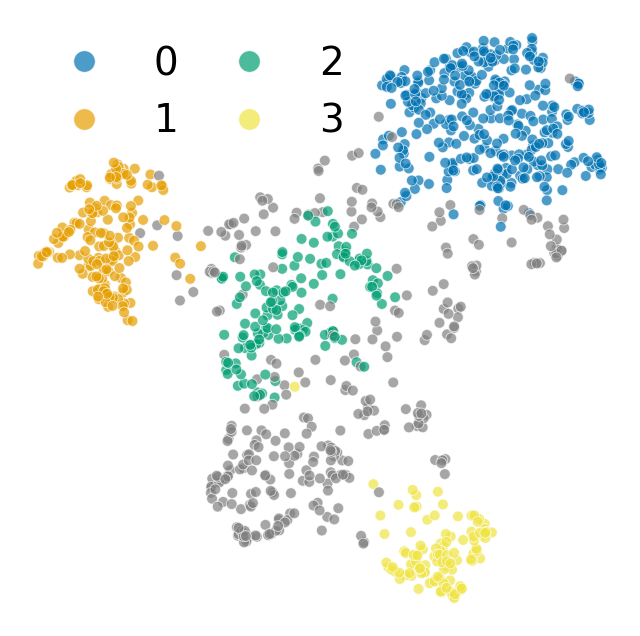

In [21]:
# figure size
plt.figure(figsize=(8, 8))

dictionary_colors = {-1: "grey", 0: "#0072B2", 1: "#E69F00", 2: "#009E73",
                     3: "#F0E442", 4: "grey", 5: "grey", 6: "grey",
                     7: "grey", 8: "grey", 9: "grey"}


# scatterplot of umap embeddings
sns.scatterplot(
    data=df, 
    x="umap_topic_1",
    y="umap_topic_2",
    hue="topic",
    s=60,
    alpha=0.7,
    palette=dictionary_colors
)

# remove axis
plt.gca().axes.get_xaxis().set_visible(False)
plt.gca().axes.get_yaxis().set_visible(False)

# remove spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)

# remove -1 from legend and adjust
handles, labels = plt.gca().get_legend_handles_labels()
# sort both labels and handles by labels
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: int(t[0])))
labels = [label for label in labels if label not in ["-1", "4", "5", "6", "7", "8"]]
print(labels)
# fix handles according to labels
handles = handles[1:]
plt.legend(handles, labels,
    fontsize=28,         # Adjust font size
    markerscale=2,       # Increase marker size
    loc='upper left',   # Place legend inside the plot
    ncol=2,               # Single-column legend
    framealpha = 0.0,    # No border
    columnspacing=0.8)

# remove box around legend
plt.gca().get_legend().get_frame().set_linewidth(0.0)

plt.show()

['0', '1', '2', '3', '4', '5', '6', '7', '8']


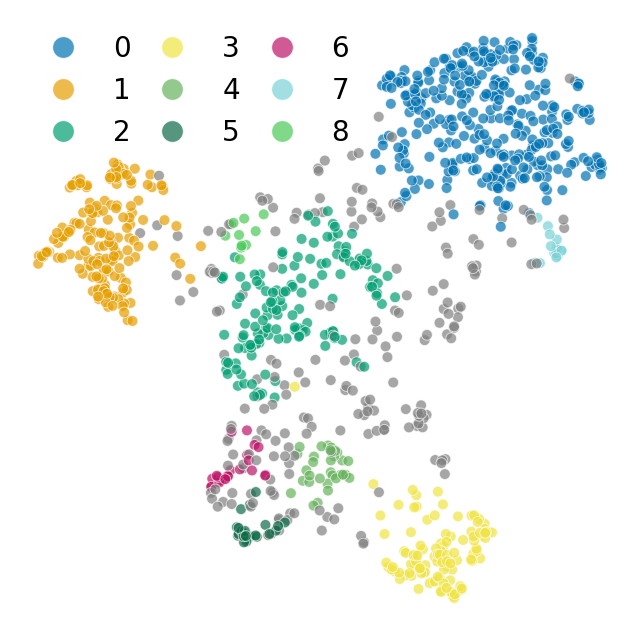

In [22]:
# figure size
plt.figure(figsize=(8, 8))

dictionary_colors = {-1: "grey", 0: "#0072B2", 1: "#E69F00", 2: "#009E73",
                     3: "#F0E442", 4: "#66b35c", 5: "#0e6a47", 6: "#bc1466",
                     7: "#79d2d6", 8: "#4aca57"}


# scatterplot of umap embeddings
sns.scatterplot(
    data=df, 
    x="umap_topic_1",
    y="umap_topic_2",
    hue="topic",
    s=60,
    alpha=0.7,
    palette=dictionary_colors
)

# remove axis
plt.gca().axes.get_xaxis().set_visible(False)
plt.gca().axes.get_yaxis().set_visible(False)

# remove spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)

# remove -1 from legend and adjust
handles, labels = plt.gca().get_legend_handles_labels()
# sort both labels and handles by labels
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: int(t[0])))
labels = [label for label in labels if label not in ["-1"]]
print(labels)
# fix handles according to labels
handles = handles[1:]
plt.legend(handles, labels,
    fontsize=20,         # Adjust font size
    markerscale=2,       # Increase marker size
    loc='upper left',   # Place legend inside the plot
    ncol=3,               # Single-column legend
    framealpha = 0.0,    # No border
    columnspacing=0.5)

# remove box around legend
plt.gca().get_legend().get_frame().set_linewidth(0.0)

plt.show()

In [23]:
df["dataset"] = df["dataset"].str.replace("vaccine", "intj")
df["dataset"] = df["dataset"].str.replace("gamestop", "wallstreetbets")

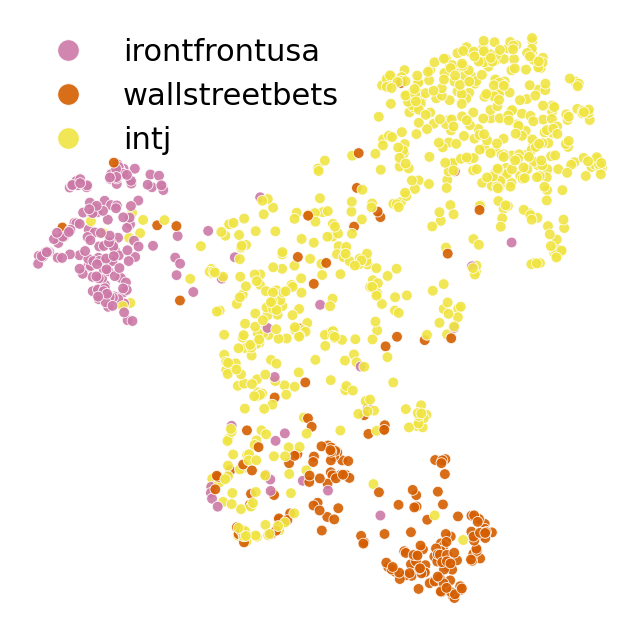

In [24]:
# figure size
plt.figure(figsize=(8, 8))

# Updated palette for better contrast
palette = ["#CC79A7", "#D55E00", "#F0E442"]  # Purple, Yellow, Red

# Scatterplot of UMAP embeddings with colors corresponding to the datasets
sns.scatterplot(
    data=df,
    x="umap_topic_1",
    y="umap_topic_2",
    hue="dataset",      # Assuming 'dataset' column contains categories to differentiate
    s=60,               # Slightly larger markers for visibility
    alpha=0.9,          # Adjusted transparency
    palette=palette     # Updated color palette
)

# Remove axis for cleaner look
plt.gca().axes.get_xaxis().set_visible(False)
plt.gca().axes.get_yaxis().set_visible(False)

# Remove spines for a minimalistic look
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)

# Adjust legend placement and style
plt.legend(
    fontsize=22,         # Adjust font size for readability
    markerscale=2,       # Increase marker size in the legend
    ncol=1,               # Single-column legend for clarity
    framealpha=0.0       # Remove legend box
)

# Remove box around the legend
plt.gca().get_legend().get_frame().set_linewidth(0.0)

plt.show()

# Compare with our classification

Open inference results on topic model data

In [25]:
data1 = pd.read_csv("../data/predictions/predictions_roberta_simplified_synthetic_weights_topic_ironfrontusa.csv")

In [26]:
data2 = pd.read_csv("../data/predictions/predictions_roberta_simplified_synthetic_weights_topic.csv")

In [27]:
data2["dataset"].value_counts()

vaccine     679
gamestop    200
Name: dataset, dtype: int64

In [28]:
df["dataset"].value_counts()

intj              679
wallstreetbets    200
irontfrontusa     180
Name: dataset, dtype: int64

In [29]:
data = pd.concat([data1, data2])

In [30]:
df.columns, data.columns

(Index(['id', 'text', 'dataset', 'body_clean', 'umap_topic_1', 'umap_topic_2',
        'topic'],
       dtype='object'),
 Index(['id', 'subreddit', 'link_id', 'parent_id', 'created_at', 'author',
        'text', 'predictions', 'class_probabilities', 'date', 'body',
        'dataset'],
       dtype='object'))

In [31]:
# get "dataset" from df
data = data.merge(df[["text", "id", "dataset", "umap_topic_1", "umap_topic_2"]], on="text")

In [32]:
data["classification_action"] = ["Participation in\ncollective action" if x == 0 else "None" for x in data["predictions"]]

In [33]:
data.columns

Index(['id_x', 'subreddit', 'link_id', 'parent_id', 'created_at', 'author',
       'text', 'predictions', 'class_probabilities', 'date', 'body',
       'dataset_x', 'id_y', 'dataset_y', 'umap_topic_1', 'umap_topic_2',
       'classification_action'],
      dtype='object')

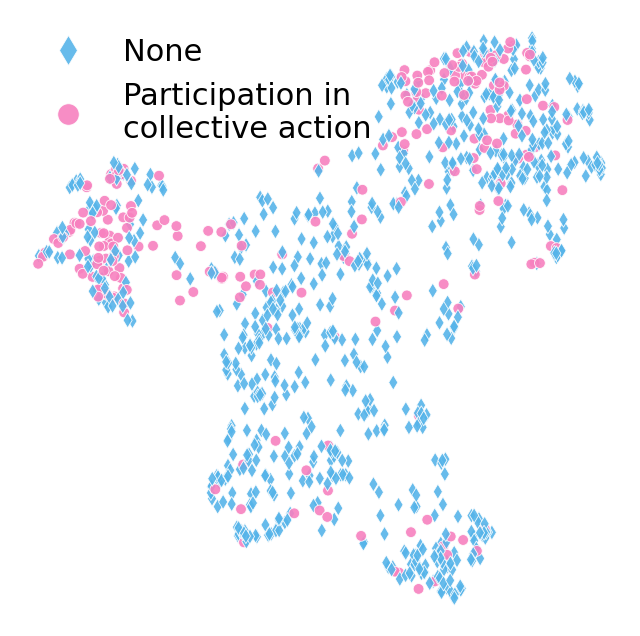

In [34]:
# figure size
plt.figure(figsize=(8, 8))

# scatterplot of umap embeddings, with colors corresponding to the topics (and shapes corresponding to the datasets
# use "color" and "marker" columns to color and shape the points
palette = ["#56B4E9", "#F781BF"]

sns.scatterplot(data=data, x="umap_topic_1", y="umap_topic_2", hue="classification_action", s=60, alpha=0.9, 
                style="classification_action", palette=palette, markers={"Participation in\ncollective action": "o", "None": "d"},)

# remove axis
plt.gca().axes.get_xaxis().set_visible(False)
plt.gca().axes.get_yaxis().set_visible(False)

# remove spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)

# increase font size of legend
plt.legend(
    fontsize=22,         # Adjust font size for readability
    markerscale=2,       # Increase marker size in the legend
    ncol=1,               # Single-column legend for clarity
    framealpha=0.0
)

# remove box around legend
plt.gca().get_legend().get_frame().set_linewidth(0.0)

plt.show()


# Topic modeling applied on our test data

In [35]:
data = pd.read_csv("../data/test_set.csv")

# change "Non-action" to "None" in the simplified_label column
data["simplified_label"] = ["None" if x=="None" else "Action" for x in data["SimplifiedLabel"]]
data["text"] = data["ActionFocusedText"]

df_test = data.copy()

In [36]:
# load nltk stopwords
stop_words = set(stopwords.words('english'))
df_test["text_clean"] = df_test["text"].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in stop_words]))
# eliminate words that are too frequent
from collections import Counter

cnt = Counter()
for text in df_test["text_clean"].values:
    for word in text.split():
        cnt[word] += 1

FREQWORDS = set([w for (w, wc) in cnt.most_common(30)])

def remove_freqwords(text):
    """custom function to remove the frequent words"""
    return " ".join([word for word in str(text).split() if word not in FREQWORDS])

df_test["text_clean"] = df_test["text_clean"].apply(lambda text: remove_freqwords(text))

In [37]:
# defone umap model and fix seed
umap_model = UMAP(random_state=0)
model = BERTopic(language="english", umap_model=umap_model)
topics, _ = model.fit_transform(df_test['text_clean'])

In [38]:
## print the topics
print(model.get_topic_info())

    Topic  Count                                           Name  \
0      -1    284                         -1_take_water_do_thats   
1       0    150                   0_us_abortion_activists_that   
2       1     63                          1_men_fight_rape_stop   
3       2     59                    2_animal_animals_vegan_meat   
4       3     40                        3_school_kids_job_class   
5       4     37                    4_israel_jews_israeli_peace   
6       5     28                      5_dont_decision_its_clear   
7       6     26                      6_russia_war_regime_assad   
8       7     23                7_meds_ive_behavior_compromised   
9       8     20               8_voting_election_candidate_2018   
10      9     20          9_dyslexia_processing_issues_disorder   
11     10     19            10_feminist_feminists_feminism_mens   
12     11     16                        11_hsv_herpes_virus_pcr   
13     12     13                12_strike_workers_employees_il

In [39]:
topic_labels = model.generate_topic_labels()

In [40]:
# assign topic labels to the test data
df_test["topic"] = topics

df_test["topic_name"] = df_test["topic"].apply(lambda x: topic_labels[x])

Topical distance

In [41]:
topic_embeddings = model.topic_embeddings_	

distances = cosine_similarity(topic_embeddings)

# table of distances
df_distances = pd.DataFrame(distances, columns=topic_labels, index=topic_labels)
df_distances

,-1_take_water_do,0_us_abortion_activists,1_men_fight_rape,2_animal_animals_vegan,3_school_kids_job,4_israel_jews_israeli,5_dont_decision_its,6_russia_war_regime,7_meds_ive_behavior,8_voting_election_candidate,9_dyslexia_processing_issues,10_feminist_feminists_feminism,11_hsv_herpes_virus,12_strike_workers_employees,13_circumcision_frenulum_circumcised
-1_take_water_do,1.000000,0.897824,0.744881,0.658872,0.556405,0.525573,0.666177,0.517383,0.489765,0.529072,0.373452,0.643163,0.428015,0.624414,0.423555
0_us_abortion_activists,0.897824,1.000000,0.647948,0.648125,0.383092,0.585126,0.572380,0.549485,0.372232,0.531332,0.266430,0.683226,0.388264,0.519053,0.333686
1_men_fight_rape,0.744881,0.647948,1.000000,0.405339,0.492573,0.395367,0.495368,0.356617,0.454957,0.341438,0.280316,0.561093,0.262721,0.390499,0.284948
2_animal_animals_vegan,0.658872,0.648125,0.405339,1.000000,0.345034,0.355135,0.375991,0.274636,0.270680,0.360165,0.161698,0.478215,0.385434,0.384801,0.282720
3_school_kids_job,0.556405,0.383092,0.492573,0.345034,1.000000,0.133747,0.324079,0.162812,0.448460,0.222547,0.412207,0.244797,0.227230,0.453052,0.148112
4_israel_jews_israeli,0.525573,0.585126,0.395367,0.355135,0.133747,1.000000,0.346598,0.594801,0.181305,0.222384,0.131259,0.371141,0.194885,0.242308,0.186472
5_dont_decision_its,0.666177,0.572380,0.495368,0.375991,0.324079,0.346598,1.000000,0.466030,0.296678,0.397734,0.254571,0.389957,0.312050,0.355376,0.224807
6_russia_war_regime,0.517383,0.549485,0.356617,0.274636,0.162812,0.594801,0.466030,1.000000,0.188537,0.304770,0.057651,0.309182,0.240699,0.281050,0.098290
7_meds_ive_behavior,0.489765,0.372232,0.454957,0.270680,0.448460,0.181305,0.296678,0.188537,1.000000,0.154663,0.567659,0.236490,0.357286,0.236631,0.226117
8_voting_election_candidate,0.529072,0.531332,0.341438,0.360165,0.222547,0.222384,0.397734,0.304770,0.154663,1.000000,0.139938,0.280300,0.252986,0.298849,0.216964


Visualize topics

## Look at UMAP

In [42]:
# use sentence transformer 'all-MiniLM-L6-v2' to embed the "body_clean" text
emb_model = SentenceTransformer('all-MiniLM-L6-v2')

embeddings = emb_model.encode(df_test['text_clean'].to_list(), show_progress_bar=True)

Batches:   0%|          | 0/26 [00:00<?, ?it/s]

In [43]:
# umap to reduce the dimensionality of the embeddings
umap_embeddings = UMAP(n_components=2,metric='cosine',random_state=100).fit_transform(embeddings)

In [44]:
df_test["umap_topic_1"] = umap_embeddings[:, 0]
df_test["umap_topic_2"] = umap_embeddings[:, 1]

df_test["topic"] = topics

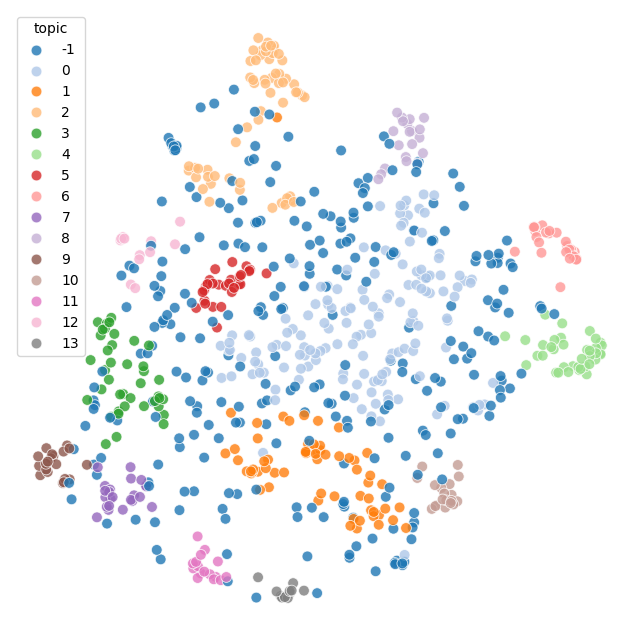

In [45]:
# figure size
plt.figure(figsize=(8, 8))

# scatterplot of umap embeddings, with colors corresponding to the topics (and shapes corresponding to the datasets
# use "color" and "marker" columns to color and shape the points
sns.scatterplot(data=df_test, x="umap_topic_1", y="umap_topic_2", hue="topic", s=60, alpha=0.8, palette="tab20")

# remove axis
plt.gca().axes.get_xaxis().set_visible(False)
plt.gca().axes.get_yaxis().set_visible(False)

# remove spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)

plt.show()


# Compare with our classification

Open inference results on topic model data

In [46]:
data = pd.read_csv("../data/predictions/predictions_roberta_simplified_synthetic_weights.csv")

In [48]:
df_test["classification_action"] = ["Committed to collective action" if x == 0 else "Non-committed" for x in data["predictions"]]

In [49]:
# table topic vs classification_action
table = pd.crosstab(df_test["topic_name"], df_test["classification_action"], normalize="index")
table

classification_action,Committed to collective action,Non-committed
topic_name,,
-1_take_water_do,0.433333,0.566667
0_us_abortion_activists,0.222222,0.777778
10_feminist_feminists_feminism,0.250000,0.750000
11_hsv_herpes_virus,0.230769,0.769231
12_strike_workers_employees,0.272727,0.727273
13_circumcision_frenulum_circumcised,0.376761,0.623239
1_men_fight_rape,0.491525,0.508475
2_animal_animals_vegan,0.275000,0.725000
3_school_kids_job,0.378378,0.621622


In [50]:
# remove index
table.reset_index(inplace=True)

In [51]:
table

classification_action,topic_name,Committed to collective action,Non-committed
0,-1_take_water_do,0.433333,0.566667
1,0_us_abortion_activists,0.222222,0.777778
2,10_feminist_feminists_feminism,0.250000,0.750000
3,11_hsv_herpes_virus,0.230769,0.769231
4,12_strike_workers_employees,0.272727,0.727273
5,13_circumcision_frenulum_circumcised,0.376761,0.623239
6,1_men_fight_rape,0.491525,0.508475
7,2_animal_animals_vegan,0.275000,0.725000
8,3_school_kids_job,0.378378,0.621622
9,4_israel_jews_israeli,0.357143,0.642857


In [52]:
df = table.copy()

In [53]:
# remove topic starting with -1
df = df[df["topic_name"].str.startswith("-1")==False]

In [55]:
# rename topics

dict_names = {"0_us_abortion_activists": "abortion",
              "10_feminist_feminists_feminism": "feminism",
              "11_hsv_herpes_virus": "herpes",
              "12_strike_workers_employees": "workers strike",
              "13_circumcision_frenulum_circumcised": "circumcision",
              "1_men_fight_rape": "men and rape",
              "2_animal_animals_vegan": "animal protection",
              "3_school_kids_job": "school and kids",
              "4_israel_jews_israeli": "isreal",
              "5_dont_decision_its": "decision making",
              "6_russia_war_regime": "russia",
              "7_meds_ive_behavior": "medication",
              "8_voting_election_candidate": "voting",
              "9_dyslexia_processing_issues": "dyslexia"}

In [56]:
df["topic_name"] = df["topic_name"].replace(dict_names)

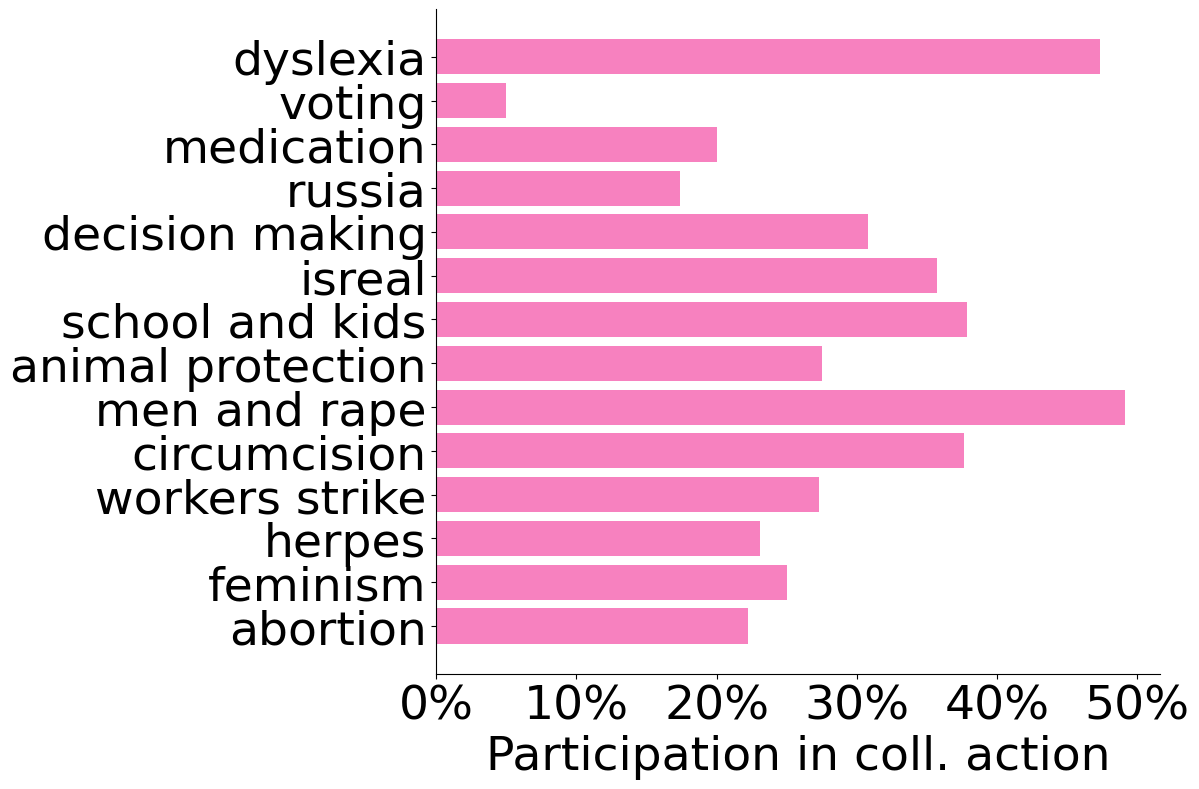

In [57]:
# Plot
fig, ax = plt.subplots(figsize=(12, 8))

# Stacked horizontal bar chart
ax.barh(df['topic_name'], df['Committed to collective action']*100, label='Committed', color='#F781BF')

# Add labels and title
ax.set_xlabel('Participation in coll. action', fontsize=34)
ax.set_yticklabels(df['topic_name'])

# Show the plot
plt.tight_layout()

# adjust the size of the ticks
plt.yticks(fontsize=34)

# add % to x-axis ticks
plt.xticks(fontsize=34)
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter())

# Remove right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Adjust layout to fit everything
plt.tight_layout()

plt.show()
